**The idea is:**

 - Feature reduction with PCA
 - Data transformation (log, hot encoding, nan)
 - Test different regression models

**Things found:**

- Applying log transformation really increases the accuracy.
- Using PCA with 36 components makes the learning and testing much (much much) faster.
- Removing columns with more than 1000 NaNs gives better result than applying "mean" to them.
- There are outliers. Instead of removing them, using Huber seems to provide a good result. Huber is a model robust to outliers.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import tflearn
import tensorflow as tf
import seaborn
import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

sample_submission.csv
test.csv
train.csv



## Data Load ##

I mix data and test to manipulate all the data just once. SalePrice is extracted to its own variable "labels". Finally, SalesPrice is remove from data.

In [2]:
train = pd.read_csv('../input/train.csv')
labels=train["SalePrice"]
test = pd.read_csv('../input/test.csv')
data = pd.concat([train,test],ignore_index=True)
data = data.drop("SalePrice", 1)
ids = test["Id"]

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Count the number of rows in train
train.shape[0]

1460

In [5]:
# Count the number of rows in total
data.shape[0]

2919

In [6]:
# Count the number of NaNs each column has.
nans=pd.isnull(data).sum()
nans[nans>0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [7]:
# Remove id and columns with more than a thousand missing values
data=data.drop("Id", 1)
data=data.drop("Alley", 1)
data=data.drop("Fence", 1)
data=data.drop("MiscFeature", 1)
data=data.drop("PoolQC", 1)
data=data.drop("FireplaceQu", 1)

In [8]:
# Count the column types
data.dtypes.value_counts()

object     38
int64      25
float64    11
dtype: int64

## Data Manipulation ##

- Apply hot encoding, convert categorical variable into dummy/indicator variables.
- Fill NaN with median for that column.
- Log transformation.
- Change -inf to 0.

In [9]:
all_columns = data.columns.values
non_categorical = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", 
                   "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
                   "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", 
                   "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
                   "ScreenPorch","PoolArea", "MiscVal"]

categorical = [value for value in all_columns if value not in non_categorical]

In [10]:
# One Hot Encoding and nan transformation
data = pd.get_dummies(data)

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
data = imp.fit_transform(data)

# Log transformation
data = np.log(data)
labels = np.log(labels)

# Change -inf to 0 again
data[data==-np.inf]=0

## Feature reduction ##

There are many features, so I am going to use PCA to reduce them. The idea is to start with n_components = number of columns. Then select the number of components that add up to 1 variance_ratio.

In [11]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([ 0.2248857 ,  0.40281429,  0.52425789,  0.62418823,  0.69580422,
        0.75944463,  0.8116806 ,  0.85647038,  0.89178708,  0.92273755,
        0.94898868,  0.95842727,  0.96637545,  0.97380464,  0.97971901,
        0.98501952,  0.98918839,  0.99199181,  0.99386559,  0.99520919,
        0.99611479,  0.99695667,  0.99771023,  0.99842564,  0.9989402 ,
        0.99933882,  0.99959949,  0.99978254,  0.99988174,  0.99993998,
        0.99998599,  0.99999658,  0.99999871,  0.99999943,  0.99999999,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [12]:
pca = PCA(n_components=36,whiten=True)
pca = pca.fit(data)
dataPCA = pca.transform(data)

## Data Model Selection ##

Simple test to run multiple models against our data. First, with raw features. No PCA.

In [13]:
# Split traing and test
train = data[:1460]
test = data[1460:]

,R Square Score
Lasso,0.853933
Linear,0.853790
Bayesian Ridge,0.852442
SVM Linear,0.849076
RandomForest,0.847274
Bagging,0.844001
Ridge,0.838624
Hubber,0.836138
SVM RBF,0.812019
AdaBoost,0.796853


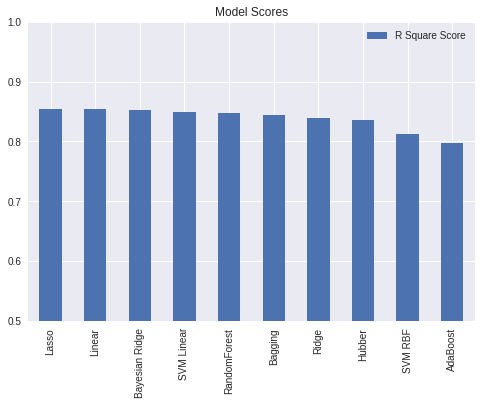

In [14]:
# R2 Score

def lets_try(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    results=results.sort(columns=["R Square Score"],ascending=False)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results

lets_try(train,labels)

Now, let's try the same but using data with PCA applied.

,R Square Score
Hubber,0.859653
SVM Linear,0.858350
Bayesian Ridge,0.853913
Lasso,0.853862
Ridge,0.853826
Linear,0.853790
SVM RBF,0.791327
Bagging,0.728002
RandomForest,0.713542
AdaBoost,0.671622


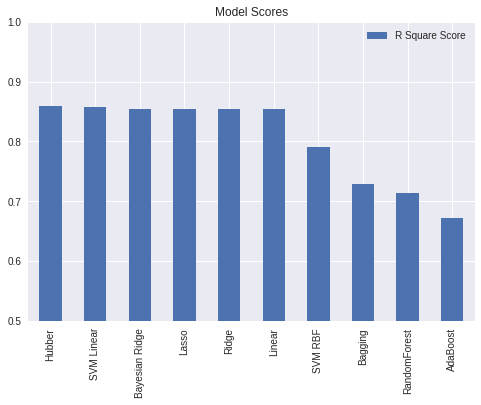

In [15]:
# Split traing and test
train = dataPCA[:1460]
test = dataPCA[1460:]

lets_try(train,labels)

In [16]:
cv = KFold(n_splits=5,shuffle=True,random_state=45)

parameters = {'alpha': [1000,100,10],
              'epsilon' : [1.2,1.25,1.50],
              'tol' : [1e-10]}

clf = linear_model.HuberRegressor()
r2 = make_scorer(r2_score)
grid_obj = GridSearchCV(clf, parameters, cv=cv,scoring=r2)
grid_fit = grid_obj.fit(train, labels)
best_clf = grid_fit.best_estimator_ 

best_clf.fit(train,labels)

HuberRegressor(alpha=100, epsilon=1.25, fit_intercept=True, max_iter=100,
        tol=1e-10, warm_start=False)

Simple Neural Network
---------------------

Now I am going to try a simple neural network, to see if i can improve the result.

In [17]:
# Shape the labels
labels_nl = labels
labels_nl = labels_nl.reshape(-1,1)

In [18]:
tf.reset_default_graph()
r2 = tflearn.R2()
net = tflearn.input_data(shape=[None, train.shape[1]])
net = tflearn.fully_connected(net, 30, activation='linear')
net = tflearn.fully_connected(net, 10, activation='linear')
net = tflearn.fully_connected(net, 1, activation='linear')
sgd = tflearn.SGD(learning_rate=0.1, lr_decay=0.01, decay_step=100)
net = tflearn.regression(net, optimizer=sgd,loss='mean_square',metric=r2)
model = tflearn.DNN(net)

In [19]:
model.fit(train, labels_nl,show_metric=True,validation_set=0.2,shuffle=True,n_epoch=50)

Training Step: 949  | total loss: 0.04229 | time: 0.150s
| SGD | epoch: 050 | loss: 0.04229 - R2: 0.9994 -- iter: 1152/1168
Training Step: 950  | total loss: 0.03959 | time: 1.157s
| SGD | epoch: 050 | loss: 0.03959 - R2: 0.9997 | val_loss: 0.02866 - val_acc: 0.9983 -- iter: 1168/1168
--


In [20]:
# Make predictions

predictions_huber = best_clf.predict(test)
predictions_DNN = model.predict(test)
predictions_huber = np.exp(predictions_huber)
predictions_DNN = np.exp(predictions_DNN)
predictions_DNN = predictions_DNN.reshape(-1,)

sub = pd.DataFrame({
        "Id": ids,
        "SalePrice": predictions_DNN
    })

sub.to_csv("prices_submission.csv", index=False)
#print(sub)